In [1]:
!uv pip install -q --system numba-cuda==0.4.0

In [2]:
import numba.cuda as cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CPU Image processing

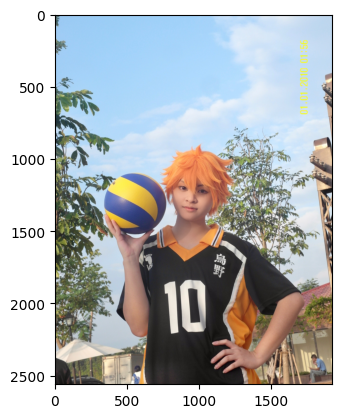

In [4]:
img_path = "/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22/IMG_8500.JPG"
img = plt.imread(img_path)
plt.imshow(img)

In [5]:
# @cuda.jit
# def grayscale(src, dst):
# # where are we in the input?
#   tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#   g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
#   dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

In [6]:
# compressed_img = img.reshape(img.shape[0]* img.shape[1], 3)
# compressed_img_cuda = cuda.to_device(compressed_img)
# print(compressed_img_cuda.shape)
# print(type(compressed_img_cuda))
# block_size = 64
# pixel_count = img.shape[0] * img.shape[1]
# grid_size = int(pixel_count/block_size)
# gray_img_cuda =  cuda.device_array((pixel_count, 1), dtype=np.uint8)
# start = time.time()
# grayscale[grid_size, block_size](compressed_img_cuda, gray_img_cuda)
# end = time.time()

# gray_img_host = gray_img_cuda.copy_to_host()
# print(f"CUDA runtime: {end-start}")
# print(gray_img_host.shape)
# gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)
# plt.imshow(gray_img, cmap="gray")

GrayScale (GPU, From Scratch)

In [7]:
# @cuda.jit
# def grayscale2d(src, dst):
# # where are we in the input?
#   tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#   tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
#   if tidx < src.shape[0] and tidy < src.shape[1]:
#     g = ((src[tidx, tidy, 0] + src[tidx, tidy, 1] + src[tidx, tidy, 2]) / 3)
#     dst[tidx, tidy, 0] = g
#     dst[tidx, tidy, 1] = g
#     dst[tidx, tidy, 2] = g




In [10]:
@cuda.jit
def gaussianblur2D(src, dst, kernel):
# where are we in the input?
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx < src.shape[0] and tidy < src.shape[1]:
    half_kernel_h = kernel.shape[0] //2
    half_kernel_w = kernel.shape[1] //2

    blur_pixel_r = 0
    blur_pixel_g = 0
    blur_pixel_b = 0

    for i in range(kernel.shape[0]):
      for j in range(kernel.shape[1]):
        x_i = tidx + i - half_kernel_h
        x_j = tidy + j - half_kernel_w

        if x_i >= 0 and x_i < src.shape[0] and x_j >= 0 and x_j < src.shape[1]:
          blur_pixel_r += src[x_i, x_j, 0] * kernel[i, j]
          blur_pixel_r += src[x_i, x_j, 1] * kernel[i, j]
          blur_pixel_r += src[x_i, x_j, 2] * kernel[i, j]

    dst[tidx, tidy, 0] = blur_pixel_r
    dst[tidx, tidy, 1] = blur_pixel_g
    dst[tidx, tidy, 2] = blur_pixel_b

Grayscale GPU 2D

(2560, 1920, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
0.06471729278564453


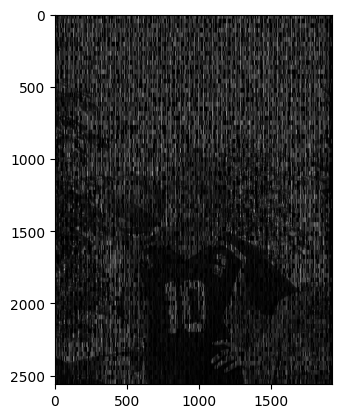

In [12]:
import math
img_cuda = cuda.to_device(img)
print(img_cuda.shape)
print(type(img_cuda))
gaussian_kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)

block_size = (32, 32)
grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))

gray_img_cuda =  cuda.device_array((img.shape[0], img.shape[1], 1))
start = time.time()
gaussianblur2D[grid_size, block_size](img_cuda, gray_img_cuda, gaussian_kernel)
end = time.time()
print(end-start)
gray_img = gray_img_cuda.copy_to_host()
# gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)

plt.imshow(gray_img, cmap="gray")

In [ ]:
# import os
# img_paths = "/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22"
# block_size = []
# for img in os.listdir(img_paths):
#   img_path = os.path.join(img_paths, img)
#   img = plt.imread(img_path)
#   img_cuda = cuda.to_device(img)
#   print(img_cuda.shape)
#   print(type(img_cuda))
#   block_size = (32, 8)
#   grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))

#   gray_img_cuda =  cuda.device_array((img.shape[0], img.shape[1], 1))
#   start = time.time()
#   grayscale2d[grid_size, block_size](img_cuda, gray_img_cuda)
#   end = time.time()
#   print(end-start)
#   gray_img = gray_img_cuda.copy_to_host()
#   # gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)


